In [1]:
# torch and torchvision imports

import torch, torch.nn as nn, torch.optim as optim
from torchmetrics.classification import MultilabelAUROC
import numpy as np,  matplotlib.pyplot as plt, pandas as pd, pickle
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from ResnetModel import *
from transformer import *
writer = SummaryWriter()
# from google.colab import drive
# drive.mount('/gdrive')
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


2023-12-08 15:31:17.081277: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 15:31:17.247721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 15:31:17.247817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 15:31:17.274004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 15:31:17.327921: I tensorflow/core/platform/cpu_feature_guar

Device: cuda


### Loading and Preparing Data

In [2]:
X_train = torch.from_numpy(np.transpose(np.load('./data/X_train.npz')['arr_0'], axes = (0,2,1))).float()
X_test = torch.from_numpy(np.transpose(np.load('./data/X_val.npz')['arr_0'], axes = (0,2,1))).float()
y_train = pd.read_csv('./data/Y_train.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()
y_test = pd.read_csv('./data/Y_val.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()

/tmp/ipykernel_22606/265309155.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  y_train = pd.read_csv('./data/Y_train.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()


In [3]:
y_train = torch.from_numpy(y_train).int()
y_test = torch.from_numpy(y_test).int()

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
x = X_train[0:1]
print(x.shape)

torch.Size([1, 12, 1000])


### Creating the Transformer Model

In [ ]:
"""Transformer needs X input as (seq_len, batch_size, channels)"""
model = Transformer(nhead=12, num_classes=3, hidden_size=128, depth=3, seq_length=200).to(device)
# resnetModel = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).to(device)

# resnetModel(X_train[0:1].to(device))
print(summary(model.to(device), (1,200,12)))

In [ ]:
(4*1024-23.86)/37.66 #Max batch size

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True)

In [6]:
"""Test AUC metric"""
ml_auroc = MultilabelAUROC(num_labels=3, average="macro", thresholds=None)
# ml_auroc(model(X_train[0:10].to(device)), train_label_mapping[0:10].to(device).int())

### Finding Max Learning rate

In [ ]:
criterion = nn.BCELoss()
epochs = 10
model = Transformer(nhead=12, num_classes=3, drop_p=0.25, hidden_size=128, depth=3, seq_length=200).to(device)
lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

In [ ]:
train_loss = []
lrs = []

for i, (signal, labels) in enumerate(train_loader):
    idx = np.random.randint(0, 1000-200)
    signal = (signal[:, :, idx:idx+200]).to(device).transpose(0,1).transpose(0,2)
    labels = labels.to(device)
    output = model(signal)
    loss = criterion(output, labels.float())
    optimizer.zero_grad()
    loss.backward()
    train_loss.append(loss.item())
    lrs.append(lr)
    lr *= 1.1

    for g in optimizer.param_groups:
        g['lr'] = lr 

    optimizer.step()

    if i > 200 or lr > 1:
        break

lrs = np.array(lrs)
train_loss = np.array(train_loss)

lr_max = lrs[np.where(train_loss == train_loss.min())[0]]

fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()


In [ ]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

In [ ]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

In [ ]:
lr_max

In [7]:
lr_max = 0.0025/10
lr = lr_max
epochs = 10
criterion = nn.BCELoss()
model = Transformer(nhead=12, num_classes=3, drop_p=0.25, hidden_size=128, depth=3, seq_length=200).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

for g in optimizer.param_groups:
    g['lr'] = lr

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


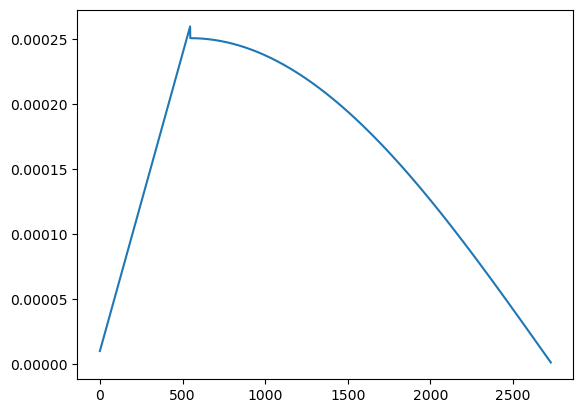

In [8]:
lrs = []
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
for t in range(T_max):
    if t <= T_0:
        lr = 10**(-5) + (t/T_0)*lr_max  
    else: 
        lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6)
    lrs.append(lr)

fig = plt.figure()
plt.plot(lrs)
plt.show()


In [9]:
lr =lr_max

In [10]:
len(range(0,800,20))

40

In [11]:
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
learning_rates = []
train_losses = []

for epoch in range(epochs):
    for i, (signal, labels) in enumerate(train_loader):
        idx = np.random.randint(0, 1000-200)
        signal_sample = (signal[:, :, idx:idx+200]).to(device).transpose(0,1).transpose(0,2)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(signal_sample)
        loss = criterion(outputs, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        if t <= T_0:
            lr = 10**(-4) + (t/T_0)*lr_max  
        else: 
            lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

        for g in optimizer.param_groups:
            g['lr'] = lr 
        learning_rates.append(lr)
        train_losses.append(loss.item())
        optimizer.step()
        t+=1
        
        train_AUC = ml_auroc(outputs, labels.int())
        writer.add_scalar("Train_Loss", loss, t)
        writer.add_scalar("Learning rate", lr, t)
        writer.add_scalar("Batch Train AUC", train_AUC, t)

        if i%(len(train_loader)//10) == 0:
            print(f"Step: {i+1}/{len(train_loader)}  |  Train loss: {loss.item():.4f}  |  Train AUC: {train_AUC:.4f}")
           

    # model.eval()
    test_auc = 0
    with torch.no_grad():
        for i, (signal, labels) in enumerate(test_loader):
            idx = np.random.randint(0, 1000-200)
            signal = (signal[:, :, idx:idx+200]).to(device).transpose(0,1).transpose(0,2)
            labels = labels.to(device)
            outputs = model(signal)
            test_auc += ml_auroc(outputs, labels.int())
        test_auc /= len(test_loader)
    writer.add_scalar("Test AUC", test_auc, epoch)

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Step: 1/273  |  Train loss: 0.6619  |  Train AUC: 0.3900
Step: 28/273  |  Train loss: 0.4562  |  Train AUC: 0.6656


/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Step: 55/273  |  Train loss: 0.4315  |  Train AUC: 0.2737
Step: 82/273  |  Train loss: 0.4125  |  Train AUC: 0.5056
Step: 109/273  |  Train loss: 0.3745  |  Train AUC: 0.6225
Step: 136/273  |  Train loss: 0.3124  |  Train AUC: 0.3757
Step: 163/273  |  Train loss: 0.3263  |  Train AUC: 0.7457
Step: 190/273  |  Train loss: 0.2879  |  Train AUC: 0.5465
Step: 217/273  |  Train loss: 0.2625  |  Train AUC: 0.3738
Step: 244/273  |  Train loss: 0.3064  |  Train AUC: 0.3020
Step: 271/273  |  Train loss: 0.3559  |  Train AUC: 0.4699
Step: 1/273  |  Train loss: 0.3925  |  Train AUC: 0.5451
Step: 28/273  |  Train loss: 0.4144  |  Train AUC: 0.5869
Step: 55/273  |  Train loss: 0.3276  |  Train AUC: 0.6804
Step: 82/273  |  Train loss: 0.3959  |  Train AUC: 0.6248
Step: 109/273  |  Train loss: 0.3037  |  Train AUC: 0.5414
Step: 136/273  |  Train loss: 0.4741  |  Train AUC: 0.6231
Step: 163/273  |  Train loss: 0.2924  |  Train AUC: 0.3818
Step: 190/273  |  Train loss: 0.3249  |  Train AUC: 0.5992
Step

In [12]:
epoch

3

In [13]:
t

34492

In [14]:
with open('superclassmodel.pickle', 'wb') as f:
    pickle.dump(model, f)